331


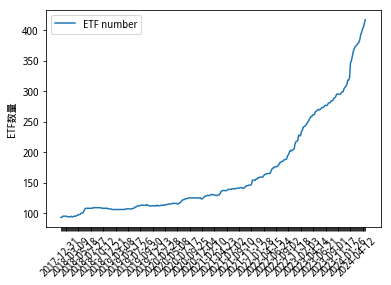

In [4]:
#实盘的时候要滚动训练，


######################################导入一堆乱七八糟的库###############################################
from jqdata import *
from jqlib.technical_analysis import *
from jqfactor import get_factor_values
from jqfactor import winsorize_med
from jqfactor import standardlize
from jqfactor import neutralize
import datetime
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
from statsmodels import regression
from six import StringIO
#导入pca
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn import metrics
from tqdm import tqdm
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import MinMaxScaler
warnings.filterwarnings("ignore")
import seaborn as sns
#获取指定周期的日期列表 'W、M、Q'
def get_period_date(peroid,start_date, end_date):
    #设定转换周期period_type  转换为周是'W',月'M',季度线'Q',五分钟'5min',12天'12D'
    stock_data = get_price('000001.XSHE',start_date,end_date,'daily',fields=['close'])
    #记录每个周期中最后一个交易日
    stock_data['date']=stock_data.index
    #进行转换，周线的每个变量都等于那一周中最后一个交易日的变量值
    period_stock_data=stock_data.resample(peroid,how='last')
    period_stock_data = period_stock_data.set_index('date').dropna()
    date=period_stock_data.index
    pydate_array = date.to_pydatetime()
    date_only_array = np.vectorize(lambda s: s.strftime('%Y-%m-%d'))(pydate_array)

    date_only_series = pd.Series(date_only_array)

    start_date = datetime.datetime.strptime(start_date, "%Y-%m-%d")
    start_date=start_date-datetime.timedelta(days=1)
    start_date = start_date.strftime("%Y-%m-%d")
    date_list=date_only_series.values.tolist()
    date_list.insert(0,start_date)
    return date_list
peroid = 'W'
start_date = '2018-01-01'
end_date = '2024-06-20'
DAY = get_period_date(peroid,start_date, end_date)
print(len(DAY))

#去除上市距beginDate不足36个月的ETF
def delect_stop(stocks,beginDate,n=30*36):
    stockList=[]
    beginDate = datetime.datetime.strptime(beginDate, "%Y-%m-%d")
    for stock in stocks:
        start_date=get_security_info(stock).start_date
        if start_date<(beginDate-datetime.timedelta(days=n)).date():
            stockList.append(stock)
    return stockList

def get_stock(begin_date):
    stockList = get_all_securities(['etf'],begin_date).index.tolist()
    stockList=delect_stop(stockList,begin_date)
    return stockList

dateList = get_period_date(peroid,start_date, end_date)
L=[]
for date in dateList[:-1]:
    stockList=get_stock(date)
    L.append(len(stockList))
interval = 10
DAY_list = [value if i % interval == 0 else None for i, value in enumerate(dateList)]
plt.plot(range(len(L)), L, label='ETF number')
plt.legend()
plt.ylabel('ETF数量')
plt.xticks(range(len(L)), DAY_list)
plt.xticks(rotation=45)
plt.show()





331


100%|██████████| 330/330 [05:25<00:00,  1.01it/s]


(54746, 60, 6)
(54746,)


100%|██████████| 20/20 [03:48<00:00, 11.41s/it]


Text(0, 0.5, 'Training Loss')

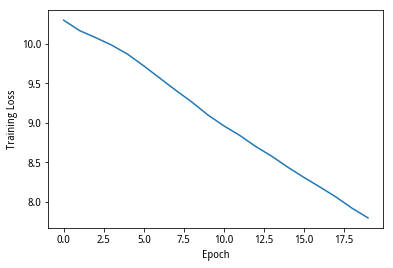

In [5]:
dateList = get_period_date(peroid,start_date, end_date)
print(len(dateList))
train_data=pd.DataFrame()
sum_arrays = []
L=[]
for date in tqdm(dateList[:-1]):
    _start_date=get_trade_days(end_date=date, count=60)
    stockList=get_stock(date)
    for i in stockList:
        df = get_price(i,  frequency='1d', 
                       start_date=_start_date[0],
                       end_date=date,
                      )
        df = df.dropna()
        if len(df) == 60:
            f_date=get_trade_days(start_date=date, count=20)
            l = get_price(i,  frequency='1d', 
               start_date=date,
               end_date=f_date[-1],
                fields=['low']
              )
            change_percentage = ((np.mean(l.values) - df['close'][-1]) / df['close'][-1]) * 100
            if not np.isnan(change_percentage):
                L.append(change_percentage)
                scaler = MinMaxScaler()
                normalized_data = scaler.fit_transform(df)
                normalized_df = pd.DataFrame(normalized_data, columns=df.columns)
                sum_arrays.append(normalized_df.values)
DATA = np.stack(sum_arrays, axis=0)
LABEL = np.stack(L)
print(DATA.shape)
print(LABEL.shape)
np.save('train_DATA_LeNet.npy', DATA)
np.save('train_LABEL_LeNet.npy', LABEL)

##################################训练模型，线上用CPU训练会有点久##########################################
############################训练过后应用就不需要在训练了##############################################
#太慢了，训练5个epoch就算了~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
import torch.nn.functional as F
import torch
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torch.optim import lr_scheduler
import torch.nn as nn
from tqdm import tqdm
train_data = np.load('train_DATA_LeNet.npy')
train_label = np.load('train_LABEL_LeNet.npy')

batch_size = 50
learning_rate = 0.0001
num_epochs = 20
MODEL = 'baseline_LeNet'

Train_data = torch.tensor(train_data, dtype=torch.float32)
Train_label = torch.tensor(train_label, dtype=torch.float32)
dataset_train = TensorDataset(Train_data, Train_label)
train_loader = DataLoader(dataset_train, shuffle=True, batch_size=batch_size)


class LeNet(nn.Module): 					# 继承于nn.Module这个父类
    def __init__(self):						# 初始化网络结构
        super(LeNet, self).__init__()    	# 多继承需用到super函数
        self.conv1 = nn.Conv2d(1, 16, 5)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32*14*1, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 1)
        self.relu = nn.ReLU()

    def forward(self, x):			 # 正向传播过程
        x = x.unsqueeze(1)
        x = self.relu(self.conv1(x))    # input(1, 60, 6) output(16, 28, 28)
        x = self.pool1(x)            # output(16, 52, 2)
        x = self.relu(self.conv2(x))    # output(32, 28, 1)
        x = self.pool2(x)            # output(32, 14, 1)
        x = x.view(-1, 32*14*1)       # output(32*14*1)
        x = self.relu(self.fc1(x))      # output(120)
        x = self.relu(self.fc2(x))      # output(84)
        x = self.fc3(x)              # output(1)
        return x

    
model = LeNet()
model.to('cpu')

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
L_train = []
L_val = []
CORR = []

for epoch in tqdm(range(num_epochs)):
    train_running_loss = 0.0
    model.train()
    for seq, y in train_loader:
        output = model(seq.to('cpu'))
        loss = criterion(output, y.unsqueeze(1).to('cpu'))
        train_running_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    TL = train_running_loss / len(train_loader)
    L_train.append(TL)

torch.save(model.state_dict(), fr"./model_{MODEL}.pt")

fig1, ax1 = plt.subplots()
ax1.plot(L_train)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Training Loss')

In [6]:
##################应用model预测明天买啥ETF#########################
######################################导入一堆乱七八糟的库###############################################
from jqdata import *
from jqlib.technical_analysis import *
from jqfactor import get_factor_values
from jqfactor import winsorize_med
from jqfactor import standardlize
from jqfactor import neutralize
import datetime
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
from statsmodels import regression
from six import StringIO
#导入pca
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn import metrics
from tqdm import tqdm
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import warnings
import torch.nn.functional as F
import torch
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torch.optim import lr_scheduler
import torch.nn as nn
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
warnings.filterwarnings("ignore")
import seaborn as sns
#去除上市距beginDate不足36个月的ETF
def delect_stop(stocks,beginDate,n=30*36):
    stockList=[]
    beginDate = datetime.datetime.strptime(beginDate, "%Y-%m-%d")
    for stock in stocks:
        start_date=get_security_info(stock).start_date
        if start_date<(beginDate-datetime.timedelta(days=n)).date():
            stockList.append(stock)
    return stockList

def get_stock(begin_date):
    stockList = get_all_securities(['etf'],begin_date).index.tolist()
    stockList=delect_stop(stockList,begin_date)
    return stockList


class LeNet(nn.Module): 					# 继承于nn.Module这个父类
    def __init__(self):						# 初始化网络结构
        super(LeNet, self).__init__()    	# 多继承需用到super函数
        self.conv1 = nn.Conv2d(1, 16, 5)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32*14*1, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 1)
        self.relu = nn.ReLU()

    def forward(self, x):			 # 正向传播过程
        x = x.unsqueeze(1)
        x = self.relu(self.conv1(x))    # input(1, 60, 6) output(16, 28, 28)
        x = self.pool1(x)            # output(16, 52, 2)
        x = self.relu(self.conv2(x))    # output(32, 28, 1)
        x = self.pool2(x)            # output(32, 14, 1)
        x = x.view(-1, 32*14*1)       # output(32*14*1)
        x = self.relu(self.fc1(x))      # output(120)
        x = self.relu(self.fc2(x))      # output(84)
        x = self.fc3(x)              # output(1)
        return x
# 创建模型实例
model = LeNet()
state_dict = torch.load("model_baseline_LeNet.pt", map_location=torch.device("cpu"))
model.load_state_dict(state_dict)

date = datetime.datetime.now().strftime("%Y-%m-%d")
_start_date=get_trade_days(end_date=date, count=60)
stockList=get_stock(date)
name = []
F = []
for i in stockList:
    df = get_price(i,  frequency='1d', 
                   start_date=_start_date[0],
                   end_date=date,
                  )
    df = df.dropna()
    if len(df) == 60:
        scaler = MinMaxScaler()
        normalized_data = scaler.fit_transform(df)
        normalized_df = pd.DataFrame(normalized_data, columns=df.columns)
        F.append(normalized_df.values)
        name.append(i)
DATA = np.stack(F, axis=0)
DATA = torch.tensor(DATA, dtype=torch.float32)
print(DATA.shape)
dataset_test = TensorDataset(DATA)
test_loader = DataLoader(dataset_test, shuffle=False, batch_size=50)
model.eval()
S=[]
with torch.no_grad():
    for seq in test_loader:
        output = model(seq[0])
        S.extend(output.numpy())
        
# 创建 DataFrame
df = pd.DataFrame({'name': name, '打分': S})
df['打分'] = df['打分'].apply(lambda x: x[0] if x else None)
# 获取打分最高的 10 个 name
top_10_names = df.nlargest(10, '打分')

LIST = []
name =[]
for i in top_10_names['name']:
    LIST.append(i)
    name.append(get_security_info(i).display_name)
TOP = pd.DataFrame({'ID': LIST, 'name': name})
# 打印 DataFrame
print(TOP)

torch.Size([440, 60, 6])
            ID        name
0  510360.XSHG       广发300
1  159965.XSHE     央视50ETF
2  510230.XSHG       金融ETF
3  510180.XSHG      180ETF
4  515360.XSHG       方正300
5  515380.XSHG  沪深300ETF泰康
6  512160.XSHG      MSCI基金
7  512070.XSHG        证券保险
8  516830.XSHG      300ESG
9  159952.XSHE    创业板ETF广发


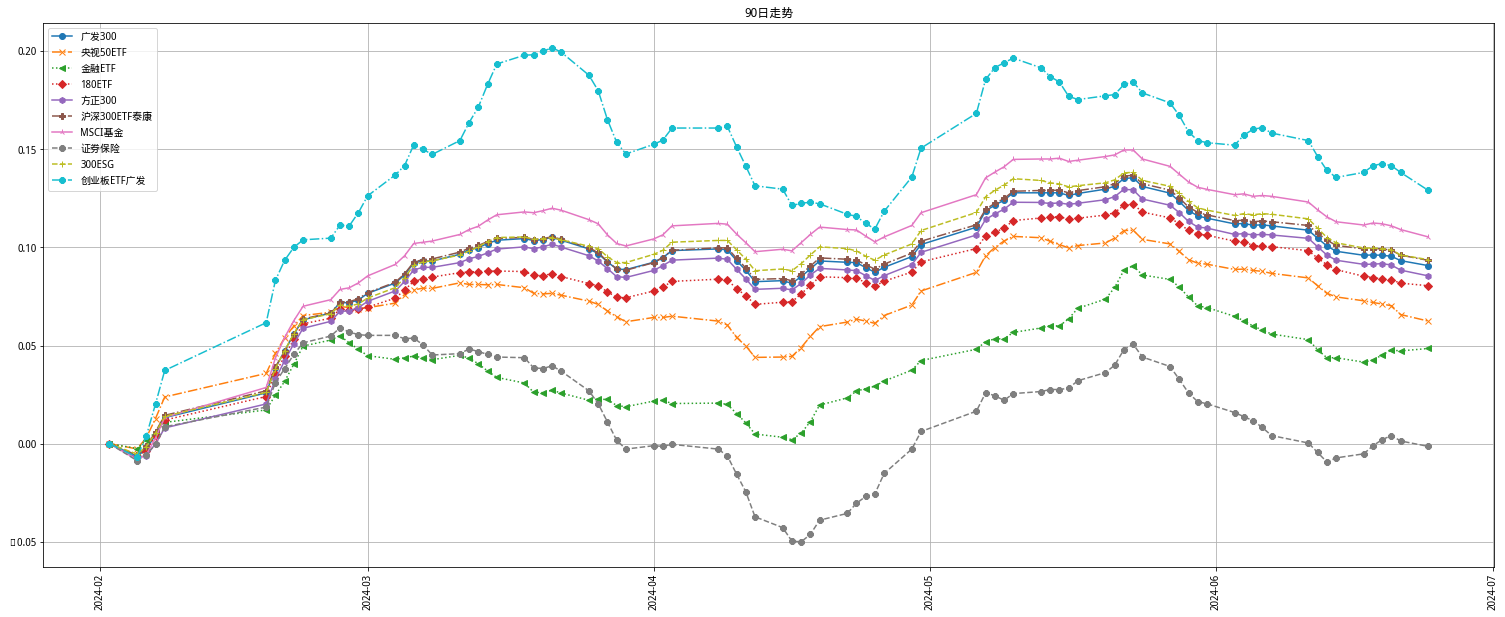

In [7]:
#######################################看看历史走势###################################
from jqdata import *
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import talib
import random


etf_list = LIST

df = get_bars(etf_list,count=200,unit='1d',fields=['date','close','volume'],include_now=False)

#获取5日平均收盘价
ma = {}
for code in etf_list:
    close = df[code]['close']
    m5 = talib.SMA(close,5)
    ma[code] = m5[-150:]

ma=pd.DataFrame(ma)


all_trd = {}
for i in range(len(etf_list)):
    tmp = list(map(lambda x:(x-ma.iloc[-90,i])/ma.iloc[-90,i],ma.iloc[-90:,i]))
    name = get_security_info(ma.columns[i]).display_name
    all_trd[name]=tmp
style = ['-','--','-.',':']
mark = '.,ov^<>12348spP*hH+xXDd|_'
fig = plt.figure(figsize(26,10))

for i in all_trd.keys():
    plt.plot(list(df[LIST[0]]['date'][-90:]),all_trd[i],label=i,marker=random.sample(mark,1)[0],linestyle=random.sample(style,1)[0])

plt.legend(loc='upper left')
plt.grid(which='major')
plt.title("90日走势")
plt.xticks(rotation=90, ha='center')
plt.show()